In [178]:
### Import
import pickle
import cv2
import math
import time
import h5py
import json
import os
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

import theano
%matplotlib inline

In [179]:
### Load data
#TODO Improve the following if possible.

# Read in CSV file
csv_loc = "data/driving_log.csv"
df = pd.read_csv(csv_loc)
df = df.drop(df[df['steering'] == 0].sample(frac=0.75).index)
#df = df.drop(df[df['throttle'] < 0.25].sample(frac=0.50).index)
print(len(df.index))
# Add c,l and r images.
features_col = pd.concat([df['center'], df['left'].map(str.strip), df['right'].map(str.strip)])
features_col = np.array(features_col.values.tolist())

# Add steering angles for c,l,r with added shift for l and r images
l_shift = 0.05 # Higher offset causes larger jumps
r_shift = -0.05
labels_c = df['steering']
labels_r = df['steering'] + r_shift
labels_l = df['steering'] + l_shift
labels_col = pd.concat([labels_c, labels_l, labels_r])
labels_col = np.array(labels_col.values.tolist())

print("Length of Features: {0}, Labels: {1}".format(len(features_col), len(labels_col)))

# Split csv data
features_col, labels_col = shuffle(features_col, labels_col)
X_train, X_val, y_train, y_val = train_test_split(features_col, labels_col, test_size=0.15, random_state=42232) 

# Read in image list
images = os.listdir("data/IMG/")

4765
Length of Features: 14295, Labels: 14295


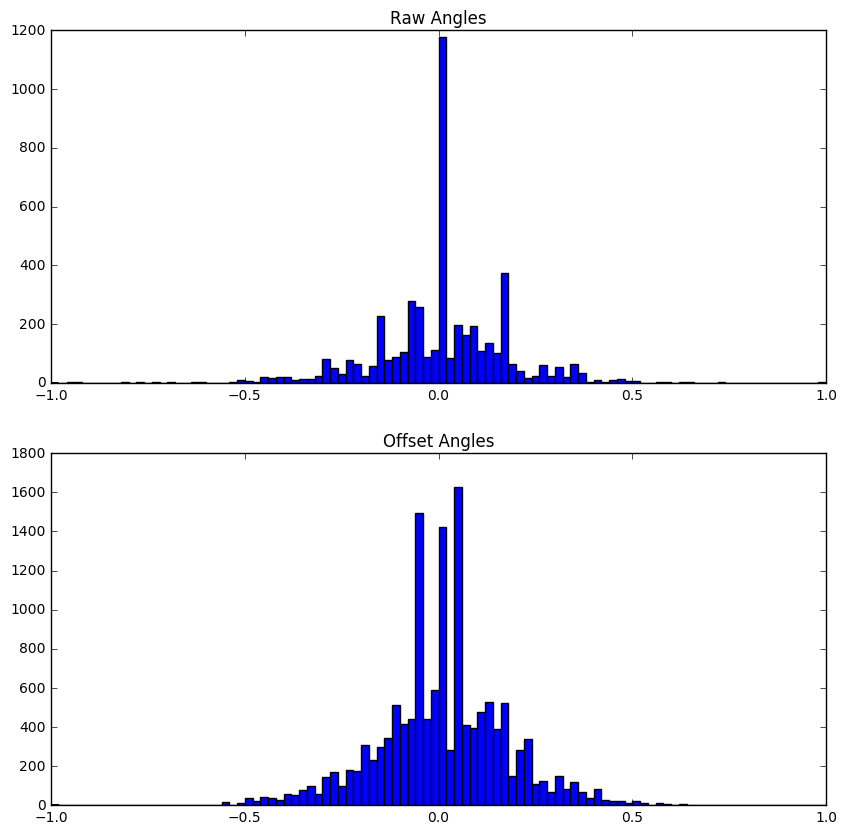

In [180]:
### Plot data
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_title("Raw Angles")
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_title("Offset Angles")

ax1.hist(df['steering'], bins=100, range=(-1,1));
ax2.hist(labels_col, bins=100, range=(-1,1));
plt.show()

In [181]:
### Pre-Process
img_cols = 120
img_rows = 60
def data_brightness(image):
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    brightness_factor = .25+np.random.uniform()
    image[:,:,2] = brightness_factor*image[:,:,2]
    image = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)
    return image

def data_trans(image, label):
    trans_factor = 30*(np.random.uniform() - 0.5) # Parameters set based on original image dimensions
    trans_matrix = np.float32([[1,0,trans_factor],[0,1,trans_factor*0.1]])
    image_trans = cv2.warpAffine(image,trans_matrix,(image.shape[1],image.shape[0]))

    label = label + (2*0.4*trans_factor)/60
    #print(label)
    
    return image_trans, label
    
    
def preprocess_data(image, label, flag):
    # Crop Image
    image = image[60:140,:]
    
    # Resize
    image = cv2.resize(image, (img_cols, img_rows))
    
    # Translate image and steering angle
    if flag == "TRAIN":
        
        prob = np.random.randint(0,2)
        if prob==0:
            image = cv2.flip(image,1)
            label = -label
            #pass
        image, label = data_trans(image, label)
        image = data_brightness(image)
    return image, label

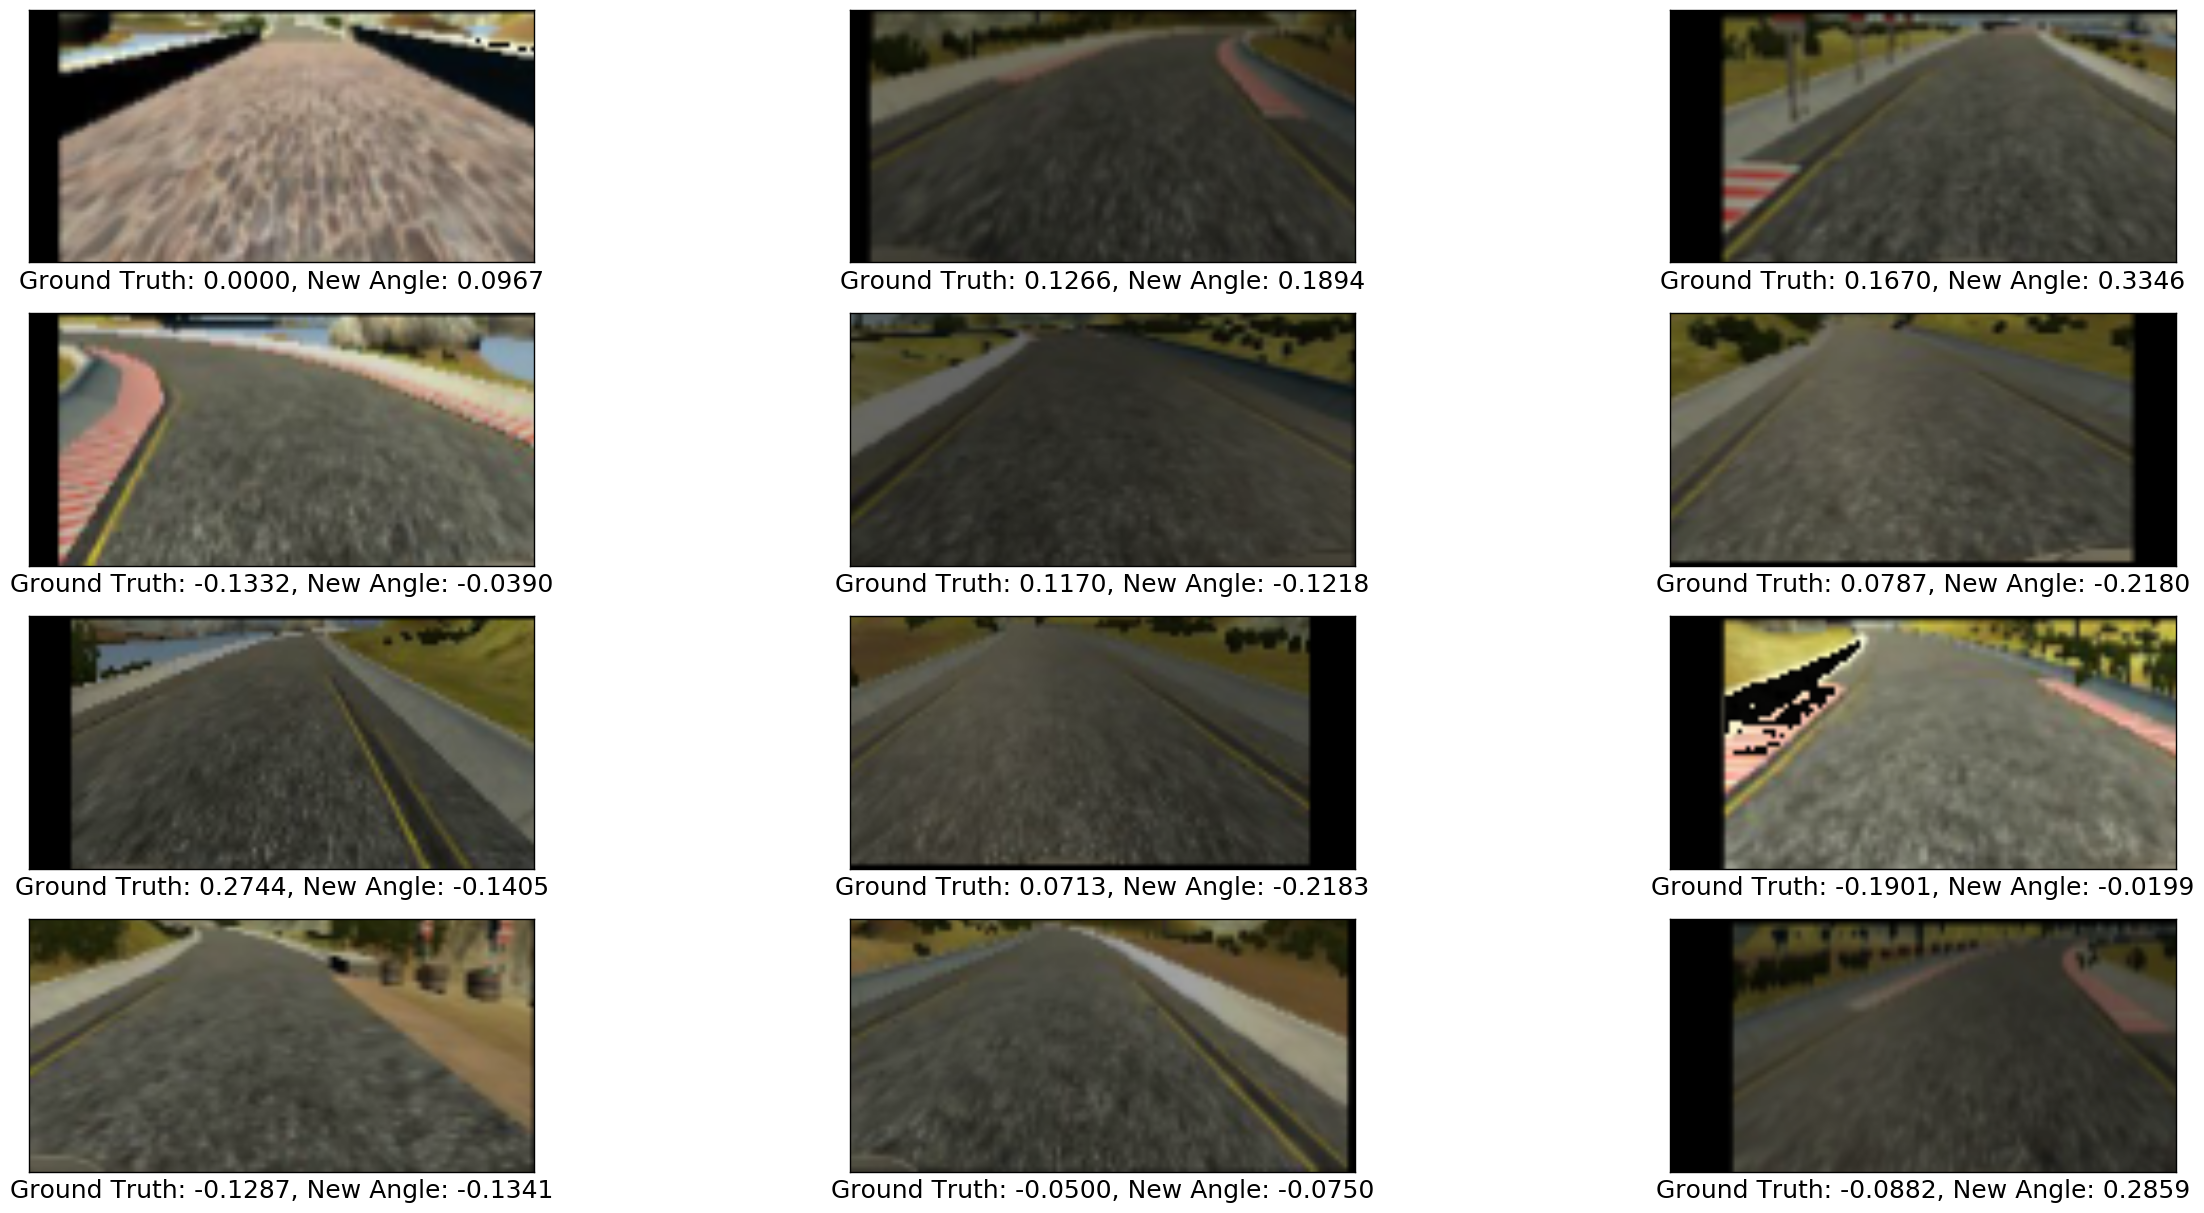

In [182]:
### Plot images
fig = plt.figure(figsize=(30, 15))

for i in range(12):
    image_seq = np.random.randint(1,len(X_train))
    image = mpimg.imread("data/" + X_train[image_seq])
    image, label = preprocess_data(image, y_train[image_seq], "TRAIN")
    
    img = fig.add_subplot(4,3,i+1)
    plt.imshow(image)
    img.set_xlabel("Ground Truth: {0:.4f}, New Angle: {1:.4f}".format(y_train[image_seq],label),fontsize=18)
    
    img.set_xticks([])
    img.set_yticks([])

plt.show()



In [183]:
### Helper Functions

def image_generator(csv_features, csv_labels, flag):
    csv_features, csv_labels = shuffle(csv_features, csv_labels)
    p = 1000
    for idx in range(len(csv_features)):
        
        label = csv_labels[idx]
        
        image = mpimg.imread("data/" + csv_features[idx])
        image, label = preprocess_data(image, label, flag)
        ''' 
        if  p < 1020 and flag == "TRAIN":
            mpimg.imsave("image" + str(p),image)
            print(label)
            p += 1
        '''
        yield image, label

epoch_labels = []
def train_data_generator(csv_features, csv_labels, batch_size):
    num_rows = int(len(csv_features))
    ctr = None
    batch_x = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_y = np.zeros(batch_size)
    while True:
        
        for i in range(batch_size):
            
            if ctr is None or ctr >= num_rows:
                ctr = 0
                images = image_generator(csv_features, csv_labels, "TRAIN")
            batch_x[i], batch_y[i] = next(images)
            ctr += 1

        yield (batch_x, batch_y)

def valid_data_generator(csv_features, csv_labels, batch_size):
    num_rows = int(len(csv_features))
    ctr = None
    batch_x = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_y = np.zeros(batch_size)
    while True:
        
        for i in range(batch_size):
            
            if ctr is None or ctr >= num_rows:
                ctr = 0
                images = image_generator(csv_features, csv_labels, "VALID")
            batch_x[i], batch_y[i] = next(images)
            ctr += 1
        
        yield (batch_x, batch_y)
        
print(X_train.shape)

(12150,)


In [184]:
### Parameters
layer_1_depth = 16
layer_2_depth = 32
layer_3_depth = 32
filter_size_1 = 8
filter_size_2 = 5
filter_size_3 = 3
num_neurons_1 = 256
num_neurons_2 = 128
epochs = 10
batch_size = 64
samples_per_epoch = (X_train.shape[0]//batch_size)*batch_size

In [185]:
### Model
model = Sequential()
model.add(Lambda(lambda x: x/255.-0.5,input_shape = (img_rows, img_cols, 3)))
model.add(Convolution2D(3, 1, 1))
model.add(Convolution2D(layer_1_depth, filter_size_1, filter_size_1, border_mode = 'valid', subsample = (1,1), init = 'he_normal'))
conv_out1 = Activation('elu')
model.add(conv_out1)
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.5))
model.add(Convolution2D(layer_2_depth, filter_size_2, filter_size_2, border_mode = 'valid', subsample = (1,1), init = 'he_normal'))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.5))
model.add(Convolution2D(layer_3_depth, filter_size_3, filter_size_3, border_mode = 'valid', subsample = (1,1), init = 'he_normal'))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(num_neurons_1))
model.add(Activation('elu'))
model.add(Dropout(0.75))
model.add(Dense(num_neurons_2))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.summary()

model.compile(loss='mse',
              optimizer=Adam(lr = 0.0001),
              metrics=['mean_absolute_error'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_23 (Lambda)               (None, 60, 120, 3)    0           lambda_input_23[0][0]            
____________________________________________________________________________________________________
convolution2d_83 (Convolution2D) (None, 60, 120, 3)    12          lambda_23[0][0]                  
____________________________________________________________________________________________________
convolution2d_84 (Convolution2D) (None, 53, 113, 16)   3088        convolution2d_83[0][0]           
____________________________________________________________________________________________________
activation_135 (Activation)      (None, 53, 113, 16)   0           convolution2d_84[0][0]           
___________________________________________________________________________________________

In [186]:
### Train model
checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=0, 
                                             save_best_only=True, save_weights_only=False, mode='auto')

history = model.fit_generator(train_data_generator(X_train, y_train, batch_size),
                              samples_per_epoch=samples_per_epoch,
                              nb_epoch = epochs,
                              verbose = 1, callbacks = [checkpoint],
                              validation_data = valid_data_generator(X_val, y_val, batch_size),
                              nb_val_samples=X_val.shape[0], pickle_safe=True)


### Save model and weights
with open('model.json', 'w') as f:
    json.dump(model.to_json(), f)

#model.save_weights('model.h5')

Epoch 1/10
12096/12096 [==============================] - 95s - loss: 0.0390 - mean_absolute_error: 0.1489 - val_loss: 0.0189 - val_mean_absolute_error: 0.0960
Epoch 2/10
12096/12096 [==============================] - 93s - loss: 0.0294 - mean_absolute_error: 0.1273 - val_loss: 0.0183 - val_mean_absolute_error: 0.0965
Epoch 3/10
12096/12096 [==============================] - 93s - loss: 0.0264 - mean_absolute_error: 0.1199 - val_loss: 0.0170 - val_mean_absolute_error: 0.0909
Epoch 4/10
12096/12096 [==============================] - 93s - loss: 0.0250 - mean_absolute_error: 0.1163 - val_loss: 0.0156 - val_mean_absolute_error: 0.0875
Epoch 5/10
12096/12096 [==============================] - 93s - loss: 0.0236 - mean_absolute_error: 0.1132 - val_loss: 0.0156 - val_mean_absolute_error: 0.0897
Epoch 6/10
12096/12096 [==============================] - 93s - loss: 0.0228 - mean_absolute_error: 0.1107 - val_loss: 0.0148 - val_mean_absolute_error: 0.0843
Epoch 7/10
12096/12096 [================

(9, 24, 32)


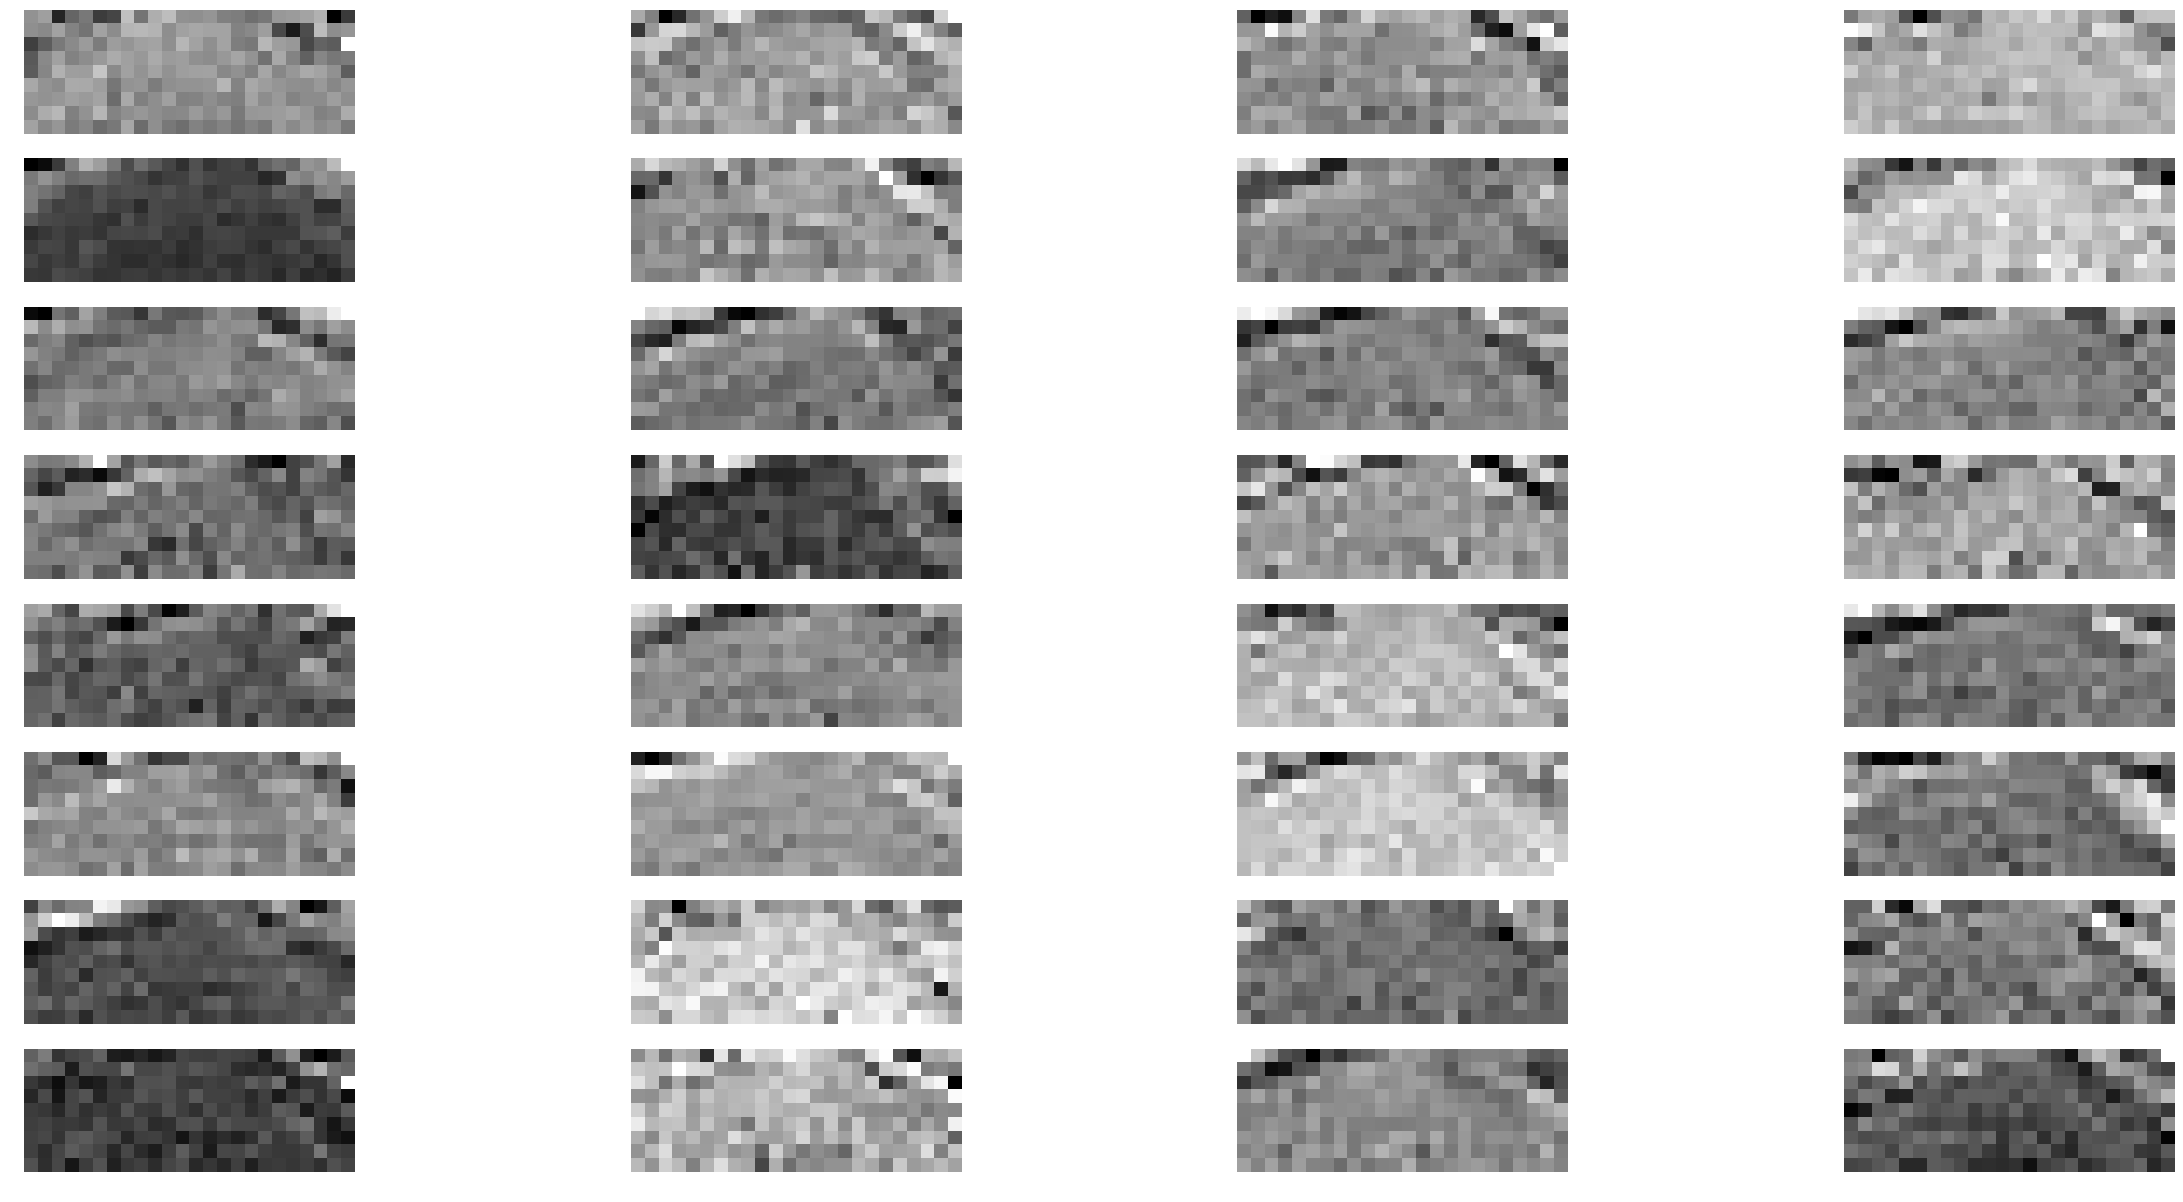

In [210]:
# visualize model layers output
from keras import backend as K
layerOutput = K.function([model.layers[0].input, K.learning_phase()],[model.layers[8].output])

idx = 4000 # this can be anything or even random
image = mpimg.imread("data/" + X_train[idx])
label = y_train[idx]
image,label = preprocess_data(image, label, "VALID")
# output in test mode = 0, train mode = 1
layerOutputSample = layerOutput([image.reshape(1,image.shape[0],image.shape[1],image.shape[2]), 1])[0]
layerOutputSample = layerOutputSample.reshape(layerOutputSample.shape[1],layerOutputSample.shape[2],layerOutputSample.shape[3])
print(layerOutputSample.shape)
figure = plt.figure(figsize=(30,15))
factors = [8,4]
for ind in range(layerOutputSample.shape[2]):
    img = figure.add_subplot(factors[0],factors[1],ind + 1)
    #plt.subplot(4, 4, ind + 1)
    val = layerOutputSample[:,:,ind]
    plt.axis("off")
    plt.imshow(val, cmap='gray',interpolation='nearest')